In [1]:
from gptopt.optim.attn_kq import *
from utils_pdhg import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

from gptopt.utils import set_seed
set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
import sys
from pathlib import Path

# Walk up until we find the repo root marker
repo_root = Path.cwd().resolve()
while repo_root != repo_root.parent and not (repo_root / "run_hydra.py").exists():
    repo_root = repo_root.parent

sys.path.insert(0, str(repo_root))

from sweeps.sweep_utils import plot_lr_sweep_over_models

# Comparison of methods to solve
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle + \frac{\mu}{2}(\|Z_1\|_F^2 + \|Z_2\|_F^2)  + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2,
\end{array} 
$$

## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \frac{1}{1 + \mu\gamma}\left (\begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right ) \right )
\end{aligned}
$$




## FISTA for dual solve

$$
\begin{array}{ll}
{\text{maximize}} &  
-\frac{1}{2\mu}\|\mathcal{A}^*(Y) + G\|_F^2 - h^*(Y)
\end{array}  
$$
recover primal using
$$
Z = -\frac{1}{\mu}(\mathcal{A}^*(Y) + G)
$$

$$
\begin{aligned}
Y^{t+1} &= \mathbf{prox}_{\frac{1}{\alpha} h^*}\left (\tilde Y^t - \frac{1}{\alpha} \mathcal{A}(\mathcal{A}^*(\tilde Y^t) + G)\right )\\
\tilde Y^{t+1} &= Y^{t+1} + \frac{k-1}{k+2} ( Y^{t+1} -  Y^t)
\end{aligned}
$$

In [4]:
n_layer = 4
std1 = 1 #0.02 / np.sqrt(2.0 * n_layer)
std2 = 1 #0.01
rank_ratio = 0.7
max_iter = 20



mu_range_fista = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 1e-4, 5e-5, 1e-5]
mu_range_pdhg = [100, 10, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 1e-4, 5e-5, 1e-5, 0]
beta = 1.

In [5]:
# Torch prox for h* (uses prox_l1 from pdhg.py)
prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
h_conj = lambda y: beta * torch.abs(y).sum()

#  $m=n=50$

In [6]:
m = n = 50
std2 = 0.1
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, 
                                        rank_ratio=rank_ratio, G_in_range=True)

mu_max = (G1.t() @ B + A.t() @ G2).abs().max().item() / beta
nA = A.pow(2).sum().sqrt().item()
nB = B.pow(2).sum().sqrt().item()
lamb_max = (nA * nA + nB * nB) ** 0.5 
print(f"{lamb_max=:.4e}, {mu_max=:.4e}")

lamb_max=7.0456e+01, mu_max=1.0548e+00


In [7]:
max_iter = 20

In [8]:
df_residuals = compare_methods_fista_pdhg_mu(A, B, G1, G2, beta, mu_range_fista=mu_range_fista,
                                mu_range_pdhg=mu_range_pdhg,
                                stopping=False, max_iter=max_iter)

Method                 Obj          Viol           Mu
-----------------------------------------------------
fista                 -1.451253e+00  0.000000e+00  1.0000e+00
pdhg                  -1.451253e+00  0.000000e+00  1.0000e+00
rehpdhg               -1.451253e+00  0.000000e+00  1.0000e+00
fista                 -2.626921e+00  1.838887e-01  5.0000e-01
pdhg                  -2.376358e+00  3.439832e-02  5.0000e-01
rehpdhg               -2.592703e+00  7.966352e-02  5.0000e-01
fista                 -5.358390e+00  1.688276e+00  1.0000e-01
pdhg                  -1.419896e+01  8.745684e+00  1.0000e-01
rehpdhg               -4.223562e+00  4.697874e-01  1.0000e-01
fista                 -7.372679e+00  3.357765e+00  5.0000e-02
pdhg                  -2.828287e+01  1.843926e+01  5.0000e-02
rehpdhg               -4.238477e+00  9.227861e-01  5.0000e-02
fista                 -2.284226e+01  1.785383e+01  1.0000e-02
pdhg                  -1.409398e+02  9.596480e+01  1.0000e-02
rehpdhg               -2

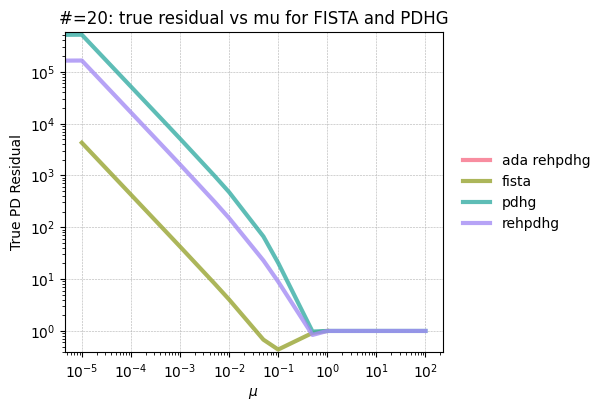

In [9]:
_ = plot_lr_sweep_over_models(df_residuals, ycol="r_true_res", xcol="mu", ylog=True,
                              title=f"#={max_iter}: true residual vs mu for FISTA and PDHG")

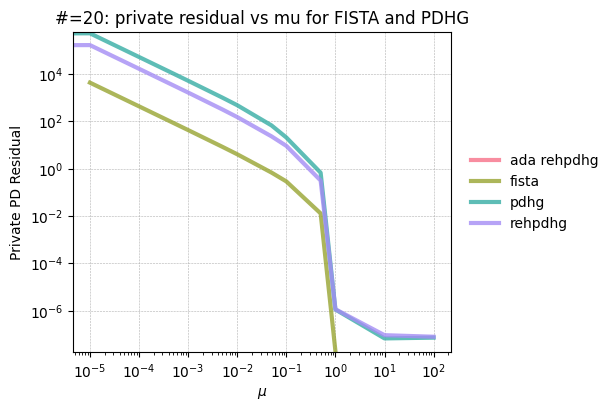

In [10]:
_ = plot_lr_sweep_over_models(df_residuals, ycol="r_res", xcol="mu", ylog=True,
                              title=f"#={max_iter}: private residual vs mu for FISTA and PDHG")

In [11]:
max_iter = 500

In [12]:
df_residuals = compare_methods_fista_pdhg_mu(A, B, G1, G2, beta, mu_range_fista=mu_range_fista,
                                mu_range_pdhg=mu_range_pdhg,
                                stopping=False, max_iter=max_iter)

Method                 Obj          Viol           Mu
-----------------------------------------------------
fista                 -1.451253e+00  0.000000e+00  1.0000e+00
pdhg                  -1.451253e+00  0.000000e+00  1.0000e+00
rehpdhg               -1.451253e+00  0.000000e+00  1.0000e+00
fista                 -2.595781e+00  1.335144e-05  5.0000e-01
pdhg                  -2.595672e+00  1.491308e-04  5.0000e-01
rehpdhg               -2.595874e+00  3.576279e-04  5.0000e-01
fista                 -4.363293e+00  7.027388e-04  1.0000e-01
pdhg                  -4.125095e+00  1.667190e-02  1.0000e-01
rehpdhg               -4.363731e+00  5.506277e-04  1.0000e-01
fista                 -4.667983e+00  2.440810e-03  5.0000e-02
pdhg                  -3.931796e+00  2.902615e-02  5.0000e-02
rehpdhg               -4.668252e+00  6.680489e-04  5.0000e-02
fista                 -4.941938e+00  1.672697e-02  1.0000e-02
pdhg                  -3.638351e+00  2.518666e-02  1.0000e-02
rehpdhg               -4

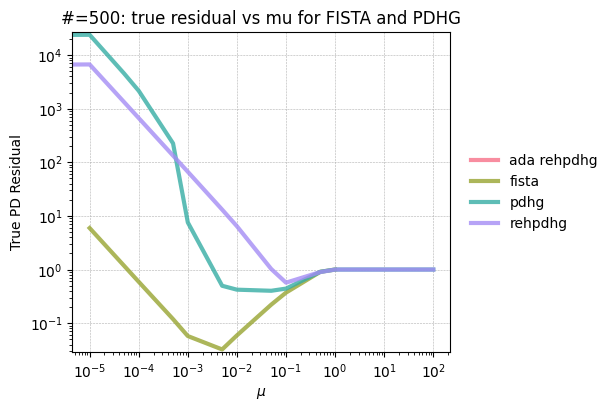

In [13]:
_ = plot_lr_sweep_over_models(df_residuals, ycol="r_true_res", xcol="mu", ylog=True,
                              title=f"#={max_iter}: true residual vs mu for FISTA and PDHG")

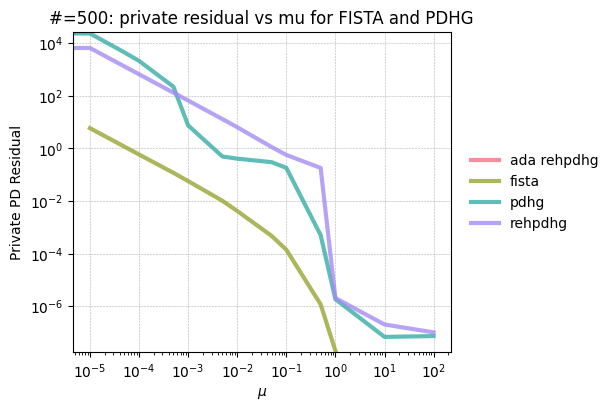

In [14]:
_ = plot_lr_sweep_over_models(df_residuals, ycol="r_res", xcol="mu", ylog=True,
                              title=f"#={max_iter}: private residual vs mu for FISTA and PDHG")